### How to name the lyric file ?
```
def safe_filename(filename):
    return re.sub(r'[<>:"/\\|?*]', '_', filename)
```

```
 file_path = f'lyrics/{safe_filename(row["Album Name"])}_{safe_filename(row["Artist Name"])}_{safe_filename(row["Title"])}.txt'
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# collect and clean all genres for each album
albums_genres = {}
for year in range(1960, 2024):
    df = pd.read_csv(f'songs_lyrics/top100_albums_{year}_songs.csv')
    df['Recording Genres'] = df['Recording Genres'].apply(lambda x: x.split(', ')) # Convert string to list
    df['Recording Genres'] = df['Recording Genres'].apply(lambda x: [genre for genre in x if genre!= 'Unknown'] if isinstance(x, list) else x)# Remove 'Unknown' genre
    df = df[df['Recording Genres'].apply(lambda x: x != [])]# Remove empty lists

    
    for album_name in df['Album Name'].unique():
        genres = df[df['Album Name'] == album_name]['Recording Genres']# Get all genres for the album
        genres = [genre for sublist in genres for genre in sublist]
        albums_genres[album_name] = set(genres)# Remove duplicates and convert to dictionary 

In [4]:
# find the suitbable threshold
import networkx as nx
import powerlaw

def jaccard_similarity(set1, set2):
    return len(set1 & set2) / len(set1 | set2)

thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]

for threshold in thresholds:
    G = nx.Graph()
    for album in albums_genres.keys():  # add nodes
        G.add_node(album)  

    album_list = list(albums_genres.keys())
    for i in range(len(album_list)):
        for j in range(i + 1, len(album_list)):
            album1, album2 = album_list[i], album_list[j]
            similarity = jaccard_similarity(albums_genres[album1], albums_genres[album2])# Calculate Jaccard similarity
            if similarity > threshold:
                G.add_edge(album1, album2, weight=similarity)
    
    G_undirected = G.to_undirected()# Convert to undirected graph
    degrees = [d for n, d in G_undirected.degree()] # Get the degree of each node
    fit = powerlaw.Fit(degrees) # Fit the degree distribution to a power law

    #print the statistics information          
    print(f"Threshold: {threshold}")
    print(f"Alpha (power law): {fit.alpha}")
    print(f"Number of nodes: {G_undirected.number_of_nodes()}")
    print(f"Number of edges: {G_undirected.number_of_edges()}")
    print(f"Average degree: {sum(dict(G_undirected.degree()).values()) / G_undirected.number_of_nodes()}")
    print(f"Number of connected components: {nx.number_connected_components(G_undirected)}")

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Threshold: 0.2 99%
Alpha (power law): 9.231406494621472
Number of nodes: 3849
Number of edges: 506472
Average degree: 263.1706936866719
Number of connected components: 55


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Threshold: 0.3 99%
Alpha (power law): 2.6085038179568434
Number of nodes: 3849
Number of edges: 155558
Average degree: 80.83034554429722
Number of connected components: 161


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Threshold: 0.4 99%
Alpha (power law): 2.211908697996863
Number of nodes: 3849
Number of edges: 44930
Average degree: 23.34632372044687
Number of connected components: 620


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Threshold: 0.5 98%
Alpha (power law): 2.4403191907341717
Number of nodes: 3849
Number of edges: 11497
Average degree: 5.974019225772928
Number of connected components: 1664
Calculating best minimal value for power law fit
Threshold: 0.6 97%
Alpha (power law): 2.286321044219643
Number of nodes: 3849
Number of edges: 4951
Average degree: 2.572616263964666
Number of connected components: 2450


Values less than or equal to 0 in data. Throwing out 0 or negative values


In [5]:
# based on the statistics information, we choose the threshold as 0.4 and build the network
G = nx.Graph()
for album in albums_genres.keys():  #add nodes
    G.add_node(album)  

# add edges
threshold = 0.4  # threshold
album_list = list(albums_genres.keys())
for i in range(len(album_list)):
    for j in range(i + 1, len(album_list)):
        album1, album2 = album_list[i], album_list[j]
        similarity = jaccard_similarity(albums_genres[album1], albums_genres[album2])
        if similarity > threshold:
            G.add_edge(album1, album2, weight=similarity)

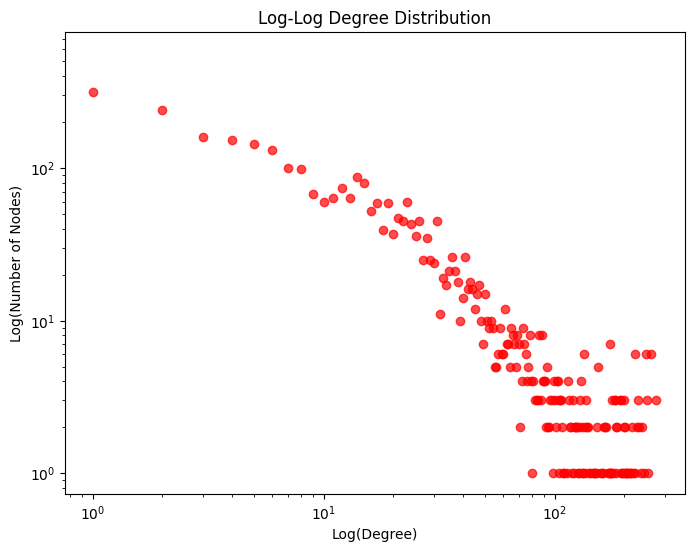

In [6]:
from collections import Counter
# draw the degree distribution
G_undirected = G.to_undirected()
degrees = [d for n, d in G_undirected.degree()]
# calculate the degree distribution
degree_count = Counter(degrees)
# exact the degree and the number of nodes
deg, cnt = zip(*degree_count.items())
# log-log plot
plt.figure(figsize=(8, 6))
plt.scatter(deg, cnt, color='red', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Log(Degree)')
plt.ylabel('Log(Number of Nodes)')
plt.title('Log-Log Degree Distribution')
plt.show()